In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

import numpy as np
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

import os
from glob import glob
import json

import cv2

Using TensorFlow backend.


In [2]:
txt = open('./data_dir_190211_linux.txt', 'r')
d_json = txt.read()
data_dir = json.loads(d_json)

In [ ]:
#img = cv2.imread(data_dir['train'][0], 0)/255

In [3]:
img_size = [44, 60]

In [4]:
x_train = np.zeros((len(data_dir['train']), img_size[0], img_size[1]))
x_valid = np.zeros((len(data_dir['valid']), img_size[0], img_size[1]))
x_test = np.zeros((len(data_dir['test']), img_size[0], img_size[1]))

In [5]:
for i in range(len(data_dir['train'])):
    temp1 = cv2.imread(data_dir['train'][i], 0)
    temp2 = cv2.resize(temp1, (img_size[1], img_size[0]), interpolation=cv2.INTER_CUBIC).astype('float32')/255
    x_train[i,:,:]  = temp2
    
for i in range(len(data_dir['valid'])):
    temp1 = cv2.imread(data_dir['valid'][i], 0)
    temp2 = cv2.resize(temp1, (img_size[1], img_size[0]), interpolation=cv2.INTER_CUBIC).astype('float32')/255
    x_valid[i,:,:]  = temp2
    
for i in range(len(data_dir['test'])):
    temp1 = cv2.imread(data_dir['test'][i], 0)
    temp2 = cv2.resize(temp1, (img_size[1], img_size[0]), interpolation=cv2.INTER_CUBIC).astype('float32')/255
    x_test[i,:,:]  = temp2

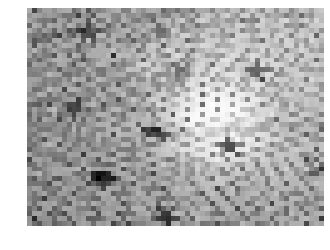

In [6]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(x_test[32], cmap='gray')
plt.show()

In [7]:
num_pix = 60*44
encoding_dim = 200

input_img = Input(shape=(num_pix,))
hidden1 = Dense(encoding_dim, activation='sigmoid')(input_img)
hidden2 = Dense(encoding_dim, activation='sigmoid')(hidden1)
hidden3 = Dense(encoding_dim, activation='sigmoid')(hidden2)
decoded = Dense(num_pix, activation='sigmoid')(hidden3)

autoencoder = Model(inputs=input_img, outputs=decoded)

In [8]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [9]:
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [10]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_valid = x_valid.reshape((len(x_valid), np.prod(x_valid.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_valid.shape)
print (x_test.shape)

(1708, 2640)
(428, 2640)
(2427, 2640)


In [11]:
trial = '5'

In [12]:
# Keras model save
dirName = './models'
if not os.path.exists(dirName):
    os.mkdir(dirName)

In [13]:
# Tensorboard log
dirName2 = './tblog%s' % trial
if not os.path.exists(dirName2):
    os.mkdir(dirName2)
tbcallback = TensorBoard(log_dir=dirName2, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

In [14]:
fpath = './models/60_44_%s.hdf5' % trial
checkpointer = ModelCheckpoint(filepath=fpath, verbose=1, save_best_only=True)

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=False,
                validation_data=(x_valid, x_valid),
                callbacks=[checkpointer, tbcallback])

Train on 1708 samples, validate on 428 samples
Epoch 1/50
1708/1708 [==============================] - 1s 352us/step - loss: 0.0313 - val_loss: 0.0280

Epoch 00001: val_loss improved from inf to 0.02796, saving model to ./models/60_44_5.hdf5
Epoch 2/50
1708/1708 [==============================] - 0s 64us/step - loss: 0.0300 - val_loss: 0.0271

Epoch 00002: val_loss improved from 0.02796 to 0.02709, saving model to ./models/60_44_5.hdf5
Epoch 3/50
1708/1708 [==============================] - 0s 45us/step - loss: 0.0283 - val_loss: 0.0249

Epoch 00003: val_loss improved from 0.02709 to 0.02485, saving model to ./models/60_44_5.hdf5
Epoch 4/50
1708/1708 [==============================] - 0s 46us/step - loss: 0.0256 - val_loss: 0.0221

Epoch 00004: val_loss improved from 0.02485 to 0.02206, saving model to ./models/60_44_5.hdf5
Epoch 5/50
1708/1708 [==============================] - 0s 49us/step - loss: 0.0227 - val_loss: 0.0203

Epoch 00005: val_loss improved from 0.02206 to 0.02033, savi

In [16]:
val_img = autoencoder.predict(x_valid)
val_losses = np.zeros(val_img.shape[0])

for i in range(val_img.shape[0]):
    val_losses[i] = mean_squared_error(x_valid[i], val_img[i])

val_st = [np.mean(val_losses), np.std(val_losses)]

In [17]:
print(val_st)

[0.017515897052233987, 0.01784669313229318]


In [18]:
test_img = autoencoder.predict(x_test)
test_losses = np.zeros(test_img.shape[0])

for i in range(test_img.shape[0]):
    test_losses[i] = mean_squared_error(x_test[i], test_img[i])
    
test_st = [np.mean(test_losses), np.std(test_losses)]

In [19]:
print(test_st)

[0.03551553123188044, 0.037157001867903904]


In [20]:
from scipy import stats

sample_num = len(val_losses)
val_sample = np.random.choice(len(val_losses), sample_num)
test_sample = np.random.choice(len(test_losses), sample_num)

t_results = stats.ttest_rel(val_losses[val_sample], test_losses[test_sample])

print(t_results)

Ttest_relResult(statistic=-8.368240056056255, pvalue=8.417870574925214e-16)


In [21]:
t_results[1]

8.417870574925214e-16

In [22]:
from scipy import stats
rv = stats.norm(val_st[0], val_st[1])

In [23]:
print(rv.cdf(test_losses[1020]))

0.31745436593706233


In [24]:
test_detect = np.zeros(len(test_losses))

for i in range(len(test_losses)):
    cdf_r = rv.cdf(test_losses[i])
    
    if cdf_r >= 0.99:
        test_detect[i] = 1


test_acc = np.mean(test_detect)
print(test_acc)

0.25710754017305315


In [25]:
correct_list = np.where(test_detect==1)
print(len(correct_list[0]))

624


In [26]:
# For saving results

if t_results[1] < 0.05:
    save_string = 'Mean Squared Error - Validation [Mean: %.5f, Std: %.5f], Test [Mean: %.5f, Std: %.5f], Statistically Diff \n' % \
    (val_st[0], val_st[1], test_st[0], test_st[1])
else:
    save_string = 'Mean Squared Error - Validation [Mean: %.5f, Std: %.5f], Test [Mean: %.5f, Std: %.5f], Statistically Not Diff \n' % \
    (val_st[0], val_st[1], test_st[0], test_st[1])

save_string = save_string + ('Torn net detection accuracy at CFD > .99: %.4f \n' % test_acc)
save_string = save_string + ('Correct List\n')

f = open("./models/statistics_trial_%s.txt" % trial, 'w')
f.write(save_string)

for i in range(len(correct_list[0])):
    temp_string = data_dir['test'][correct_list[0][i]] + '\n'
    f.write(temp_string)
f.close()

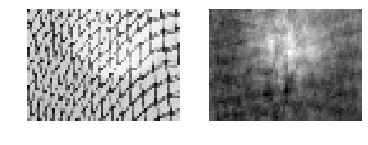

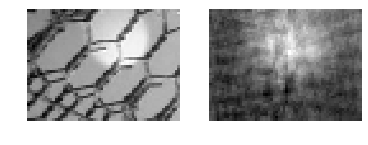

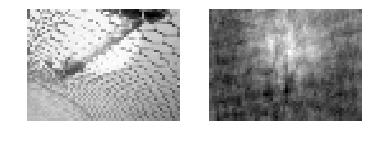

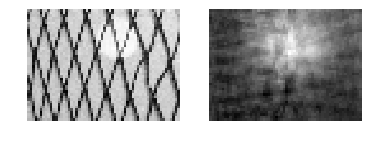

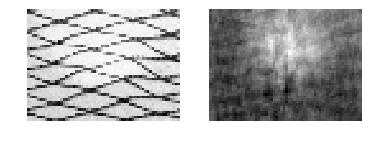

In [37]:
for i in range(5):

    idx = i

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.imshow(x_valid[idx].reshape([44, 60]), cmap='gray')
    ax2.imshow(val_img[idx].reshape([44, 60]), cmap='gray')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

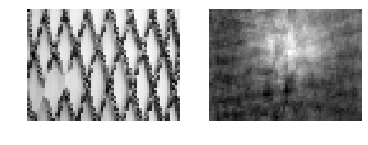

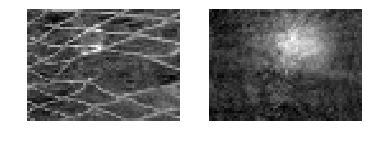

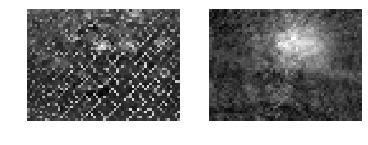

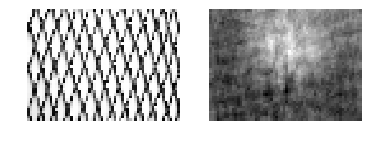

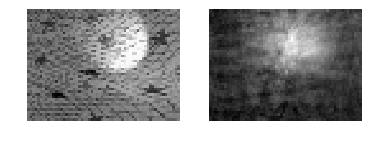

In [36]:
for i in range(5):

    idx = i

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.imshow(x_test[idx].reshape([44, 60]), cmap='gray')
    ax2.imshow(test_img[idx].reshape([44, 60]), cmap='gray')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    """
    plt.subplot(121)
    plt.axis("off")
    plt.imshow(x_test[idx].reshape([44, 60]), cmap='gray')
    plt.show()
    
    plt.subplot(122)
    plt.axis("off")
    plt.imshow(test_img[idx].reshape([44, 60]), cmap='gray')
    plt.show()
    """